In [129]:
from random import choice, choices
from string import ascii_lowercase, digits
import numpy as np
from numpy.random import default_rng

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.proportion import multinomial_proportions_confint, proportion_confint

from scipy.stats import binom
from multiprocessing import Pool
from functools import partial

import time


In [156]:
def sisson_glaz(sample_freqs, sample_probs, word_list):
    sis = pd.DataFrame(multinomial_proportions_confint(sample_freqs, method='sison-glaz'), 
                   columns=['ci_lower','ci_upper'])
    sis['exp_method'] = 'sison-glaz'
    sis['word'] = word_list
    sis['param_probs'] = sample_probs
    sis['sample_probs'] = sample_probs
    return sis[['word', 'sample_probs', 'param_probs', 'exp_method', 'ci_lower', 'ci_upper']]


def gt_orlitsky(sample, word_list):
    counts = pd.Series(sample).value_counts().reindex(word_list , fill_value=0)
    counts_of_counts = counts.value_counts()
    p = {}
    for c in (counts_of_counts.index):
        c_o_c_1 = counts_of_counts[c+1] if c+1 in counts_of_counts else 0
        if c > c_o_c_1:
            p[c] = (c/counts.sum())
        else:
            p[c] = (c_o_c_1+1) * (c+1) / (counts.sum() * counts_of_counts[c])
    new_p = counts.map(p)
    return list(new_p / new_p.sum())


In [157]:
def get_zipf_dist_probs(zipf_param, exp_alphabet_size):
    ranks = np.arange(1, exp_alphabet_size+1)
    weights = ranks ** (-zipf_param)
    exp_probs = (weights / sum(weights))
    return exp_probs


def get_uniform_dist_probs(size):
    probs = np.array([1]*size) / size
    return probs


def get_step_dist_probs(exp_alphabet_size):
    probs = [1/(2*exp_alphabet_size)]*(int(exp_alphabet_size/2)) + [3/(2*exp_alphabet_size)]*(int(exp_alphabet_size/2))
    return probs


def get_word_list(size):
    chars = ascii_lowercase + digits
    word_list = [''.join(choice(chars) for _ in range(3)) for _ in range(size*2)]
    word_list = list(set(word_list))[:size]
    word_list.sort()
    return word_list


In [158]:
def combined_ci_framwork(boot_list, ci_method, param_func_probs, sample_probs, sample_size, corrected_confidence,
                         num_of_bootstrap_smaples):
    
    if ci_method == 'good_bootstrap':
        max_probs_list = []
        for arr in boot_list: 
            if np.any(arr == 0):
                arr_prob = arr == 0
                max_prob = np.array(param_func_probs)[arr_prob].max()
                max_probs_list.append(max_prob)
        ci_bound_for_zero = np.quantile(max_probs_list,corrected_confidence, interpolation='lower')
   
    elif ci_method == 'rule_of_three':
        ci_bound_for_zero = -np.log(1-corrected_confidence)/sample_size
   
    ci_lower_list = [0]*len(sample_probs)
    ci_upper_list = [0]*len(sample_probs)
    
    for i in range(len(sample_probs)):
        if sample_probs[i] == 0:
            ci_lower_list[i] = 0
            ci_upper_list[i] = ci_bound_for_zero
        else:
            ci_lower_list[i], ci_upper_list[i] = proportion_confint(sample_probs[i]*sample_size, sample_size, 
                                                                    (1-corrected_confidence), method="beta")
    return ci_lower_list, ci_upper_list
      

In [159]:
def get_ci(boot_list, ci_method, probs, sample_size, corrected_confidence, num_of_bootstrap_smaples, sample_probs):
    boot_pct_ci = pd.DataFrame()
    boot_pct_ci['param_probs'] = probs
    
    if ci_method == 'percentile':
        boot_pct_ci['ci_lower'] = np.quantile(boot_list,(1-corrected_confidence)/2, axis=0)
        boot_pct_ci['ci_upper'] = np.quantile(boot_list,(1+corrected_confidence)/2, axis=0)

    elif ((ci_method == 'good_bootstrap') | (ci_method == 'rule_of_three')):
        boot_pct_ci['ci_lower'], boot_pct_ci['ci_upper'] = combined_ci_framwork(boot_list, ci_method, probs, 
                                                                  sample_probs, sample_size, 
                                                                  corrected_confidence, num_of_bootstrap_smaples)
    return boot_pct_ci

In [160]:
def run_parametric_bootstrap(sample_words_list, sample_probs, word_index, sample_size, num_of_bootstrap_smaples, 
                             param_dist_func, ci_method='percentile',confidence=.95, bonferroni_correction=True):
    
    bonf_corrected_alpha = (1-confidence)/len(word_index)
    corrected_confidence = 1-(bonf_corrected_alpha) if bonferroni_correction else confidence
    probs = param_dist_func(sample_words_list, word_index)
    
    boot_arr = default_rng().multinomial(sample_size, probs, size=num_of_bootstrap_smaples)
    boot_list = list(boot_arr / boot_arr.sum(axis=1, keepdims=True))

    boot_pct_ci = get_ci(boot_list, ci_method, probs, sample_size, corrected_confidence,
                        num_of_bootstrap_smaples, sample_probs)
    
    boot_pct_ci['exp_method'] = param_dist_func.__name__ + ' - ' + ci_method 

    boot_pct_ci['word'] = word_index
    boot_pct_ci['sample_probs'] = sample_probs

    return boot_pct_ci[['word', 'sample_probs', 'param_probs', 'exp_method', 'ci_lower', 'ci_upper']].reset_index(drop=True)


In [161]:
def run_experiment(sample_size, probs, word_list, dictionary, num_of_bootstrap_smaples, iteration=None):
    if iteration % 10 == 0: 
        print('iteration {}'.format(iteration))
    
    samp_exp = default_rng().multinomial(sample_size, probs, size=1).flatten()

    our_sample_exp = pd.DataFrame(np.transpose(samp_exp), index=word_list, columns=['samp'])
    our_sample_exp['probs'] = our_sample_exp['samp'] / our_sample_exp['samp'].sum()
    our_sample_raw_exp = list(np.repeat(word_list, our_sample_exp.samp))
    
    sis = sisson_glaz(our_sample_exp.samp, our_sample_exp['probs'].to_list(), word_list)
    
    contenders = [
        
        run_parametric_bootstrap(our_sample_raw_exp,our_sample_exp['probs'].to_list(), word_list, 
                                   sample_size, num_of_bootstrap_smaples, 
                                     gt_orlitsky, ci_method='good_bootstrap'),
        run_parametric_bootstrap(our_sample_raw_exp,our_sample_exp['probs'].to_list(), word_list, 
                                   sample_size, num_of_bootstrap_smaples, 
                                     gt_orlitsky, ci_method='rule_of_three')
    ]
    
    res = sis.append(pd.concat(contenders, ignore_index=True), ignore_index=True)
    res.loc[res['ci_lower'] < 0, 'ci_lower'] = 0
    res.loc[res['ci_upper'] > 1, 'ci_upper'] = 1
    res['ci_length'] = res['ci_upper'] - res['ci_lower']
    res['log_ci_length'] = np.log(res['ci_length'])
    res['exp_num'] = iteration 
    res['true_prob'] = res['word'].map(dictionary)
    res['log_true_prob'] = np.log(res['true_prob'])
    res['in_ci'] = (res['true_prob'] >= res['ci_lower']) & \
                       (res['true_prob'] <= res['ci_upper'])
    
    return res

In [162]:
exp_alphabet_size = 100

exp_probs = get_zipf_dist_probs(1.01, exp_alphabet_size)
exp_sample_size = 50

chars = ascii_lowercase + digits
exp_word_list = [''.join(choice(chars) for _ in range(3)) for _ in range(exp_alphabet_size*2)]
exp_word_list = list(set(exp_word_list))[:exp_alphabet_size]
exp_word_list.sort()
exp_dictionary = dict(zip(exp_word_list, exp_probs))

exp_bootstrap_smaples = 5000

In [163]:

experiment_runs = 100
pool = Pool(10)
func = partial(run_experiment, exp_sample_size, exp_probs, exp_word_list, exp_dictionary, exp_bootstrap_smaples)

start_time = time.time()
pooled_results = pool.starmap(func, zip(range(experiment_runs)))
pool.close()
pool.join()
print("\n *********** process run time {} minutes ***********".format((time.time() - start_time)/60))


iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90

 *********** process run time 0.40202903350194297 minutes ***********


In [164]:
exp_results = pd.concat(pooled_results)
exp_results

,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci
0,02r,0.24,0.240000,sison-glaz,0.140000,0.373342,0.233342,-1.455251,0,0.196717,-1.625990,True
1,0uh,0.12,0.120000,sison-glaz,0.020000,0.253342,0.233342,-1.455251,0,0.097679,-2.326069,True
2,0yo,0.12,0.120000,sison-glaz,0.020000,0.253342,0.233342,-1.455251,0,0.064856,-2.735589,True
3,25c,0.06,0.060000,sison-glaz,0.000000,0.193342,0.193342,-1.643296,0,0.048502,-3.026148,True
4,2d8,0.00,0.000000,sison-glaz,0.000000,0.133342,0.133342,-2.014840,0,0.038715,-3.251523,True
...,...,...,...,...,...,...,...,...,...,...,...,...
295,ywb,0.00,0.005215,gt_orlitsky - rule_of_three,0.000000,0.152018,0.152018,-1.883756,99,0.001958,-6.235982,True
296,yxv,0.00,0.005215,gt_orlitsky - rule_of_three,0.000000,0.152018,0.152018,-1.883756,99,0.001937,-6.246449,True
297,z24,0.00,0.005215,gt_orlitsky - rule_of_three,0.000000,0.152018,0.152018,-1.883756,99,0.001917,-6.256808,True
298,zjm,0.02,0.008658,gt_orlitsky - rule_of_three,0.000005,0.195390,0.195385,-1.632785,99,0.001898,-6.267062,True


In [165]:
exp_results_long = pd.melt(exp_results, id_vars=['word', 'exp_method','exp_num', 'in_ci', 'log_true_prob'], 
                           value_vars=['ci_lower', 'ci_upper', 'true_prob', 'sample_probs', 'param_probs'],
                           var_name='ci', value_name='value')
exp_results_long['true_prob'] = exp_results_long['word'].map(exp_dictionary)
exp_results_long['log_value'] = np.log(exp_results_long['value'] + .00001)
exp_results_long

,word,exp_method,exp_num,in_ci,log_true_prob,ci,value,true_prob,log_value
0,02r,sison-glaz,0,True,-1.625990,ci_lower,0.140000,0.196717,-1.966041
1,0uh,sison-glaz,0,True,-2.326069,ci_lower,0.020000,0.097679,-3.911523
2,0yo,sison-glaz,0,True,-2.735589,ci_lower,0.020000,0.064856,-3.911523
3,25c,sison-glaz,0,True,-3.026148,ci_lower,0.000000,0.048502,-11.512925
4,2d8,sison-glaz,0,True,-3.251523,ci_lower,0.000000,0.038715,-11.512925
...,...,...,...,...,...,...,...,...,...
149995,ywb,gt_orlitsky - rule_of_three,99,True,-6.235982,param_probs,0.005215,0.001958,-5.254220
149996,yxv,gt_orlitsky - rule_of_three,99,True,-6.246449,param_probs,0.005215,0.001937,-5.254220
149997,z24,gt_orlitsky - rule_of_three,99,True,-6.256808,param_probs,0.005215,0.001917,-5.254220
149998,zjm,gt_orlitsky - rule_of_three,99,True,-6.267062,param_probs,0.008658,0.001898,-4.748116


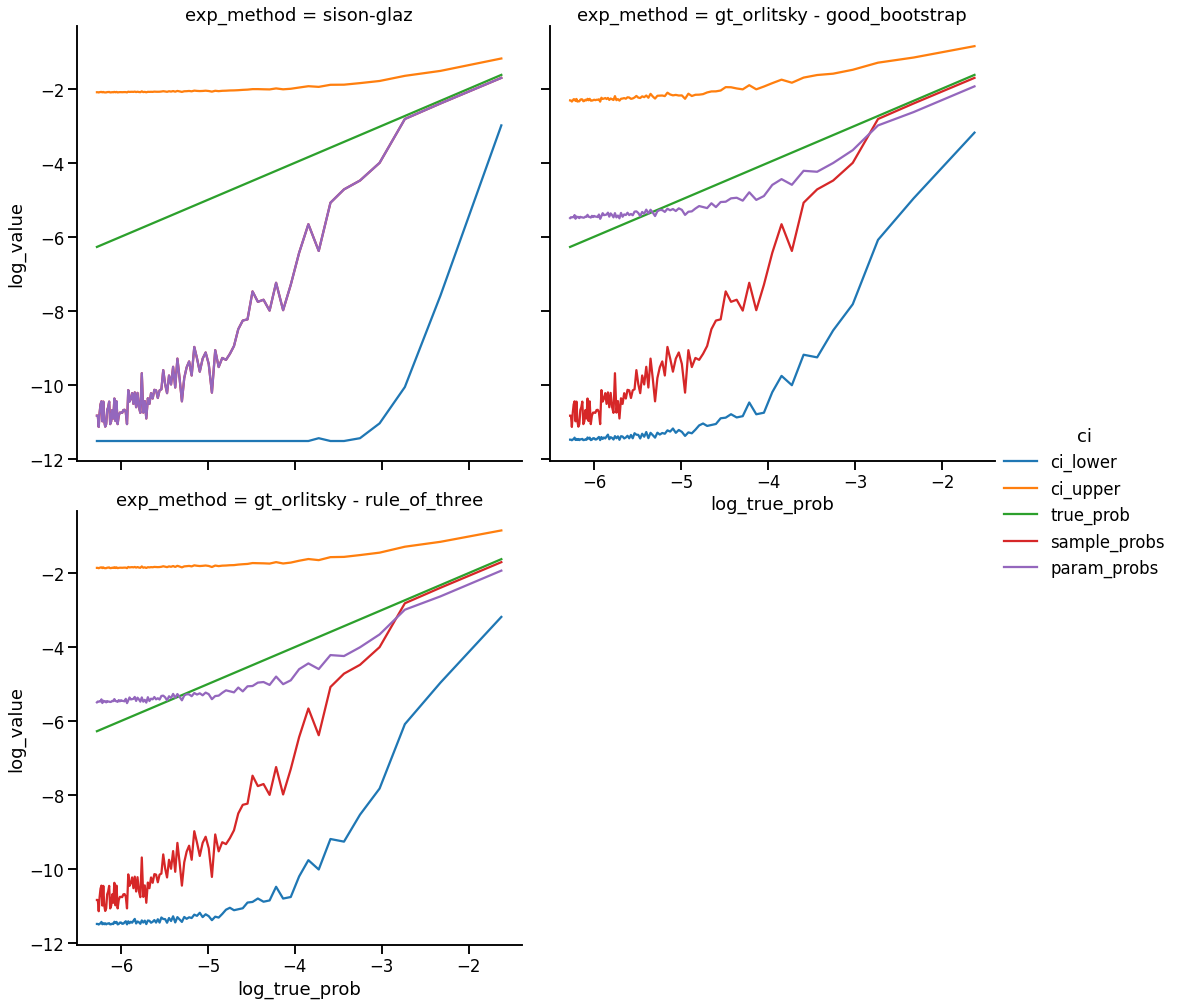

In [166]:

sns.relplot(x='log_true_prob', y='log_value', 
            hue='ci', col='exp_method', col_wrap=2, 
            kind='line', ci=None,
            height=7,
            data=exp_results_long)


In [167]:
in_ci_df = exp_results.assign(log_sample_probs=np.log(exp_results['sample_probs']+.00001)).\
groupby(['exp_num','exp_method','true_prob','log_true_prob', 'sample_probs', 'log_sample_probs', 
         'param_probs', 'ci_lower', 'ci_upper']).\
agg(in_ci = ('in_ci', 'mean'),
    count = ('true_prob', 'count')).reset_index()

in_ci_df

,exp_num,exp_method,true_prob,log_true_prob,sample_probs,log_sample_probs,param_probs,ci_lower,ci_upper,in_ci,count
0,0,gt_orlitsky - good_bootstrap,0.001879,-6.277212,0.00,-11.512925,0.004678,0.00,0.105263,1.0,1
1,0,gt_orlitsky - good_bootstrap,0.001898,-6.267062,0.00,-11.512925,0.004678,0.00,0.105263,1.0,1
2,0,gt_orlitsky - good_bootstrap,0.001917,-6.256808,0.00,-11.512925,0.004678,0.00,0.105263,1.0,1
3,0,gt_orlitsky - good_bootstrap,0.001937,-6.246449,0.00,-11.512925,0.004678,0.00,0.105263,1.0,1
4,0,gt_orlitsky - good_bootstrap,0.001958,-6.235982,0.00,-11.512925,0.004678,0.00,0.105263,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
29995,99,sison-glaz,0.038715,-3.251523,0.04,-3.218626,0.040000,0.00,0.150686,1.0,1
29996,99,sison-glaz,0.048502,-3.026148,0.02,-3.911523,0.020000,0.00,0.130686,1.0,1
29997,99,sison-glaz,0.064856,-2.735589,0.04,-3.218626,0.040000,0.00,0.150686,1.0,1
29998,99,sison-glaz,0.097679,-2.326069,0.16,-1.832519,0.160000,0.06,0.270686,1.0,1


In [168]:
in_ci_df.groupby(['exp_method', 'true_prob']).\
agg(in_ci = ('in_ci', 'mean'),
    count = ('true_prob', 'count')).reset_index()


,exp_method,true_prob,in_ci,count
0,gt_orlitsky - good_bootstrap,0.001879,1.00,100
1,gt_orlitsky - good_bootstrap,0.001898,1.00,100
2,gt_orlitsky - good_bootstrap,0.001917,1.00,100
3,gt_orlitsky - good_bootstrap,0.001937,1.00,100
4,gt_orlitsky - good_bootstrap,0.001958,1.00,100
...,...,...,...,...
295,sison-glaz,0.038715,1.00,100
296,sison-glaz,0.048502,1.00,100
297,sison-glaz,0.064856,0.98,100
298,sison-glaz,0.097679,0.98,100


In [169]:
in_ci_df[#(in_ci_df['in_ci']== False) &
         (in_ci_df['exp_method'].isin(['gt_orlitsky - our_soution_exact___',
                                      'gt_orlitsky - our_soution_boot___'])) 
        &(in_ci_df['exp_num']== 5)
        ][['param_probs', 'sample_probs', 'exp_method','ci_lower', 'ci_upper']].value_counts()#.sort_values('sample_probs', ascending=False)


Series([], dtype: int64)

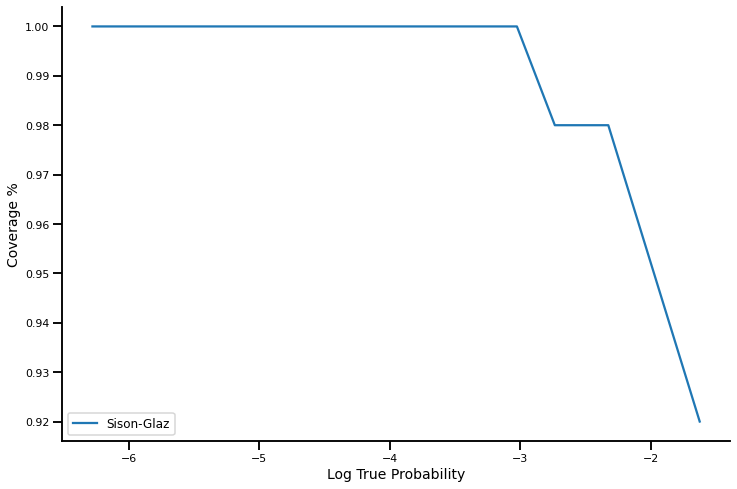

In [170]:
# fig, ax = plt.subplots()
# fig.set_size_inches(11.7, 8.27)
sns.set_context("talk")

g = sns.relplot(x='log_true_prob', y='in_ci',
                hue='exp_method', style='exp_method', #markers=True,
                kind='line', ci=None, #alpha=.55,
                height=7, aspect=1.5,
                legend=False,
                hue_order=['sison-glaz',
                              'gt_orlitsky - rule_pf_three___',
                              'gt_orlitsky - our_soution_boot___',
                              ],
            data=exp_results)
g.set_axis_labels("Log True Probability", 'Coverage %', size=14)

for ax in g.axes.flatten():
    ax.legend(labels=["Sison-Glaz", 'Rule of Three', 'Good Bootstrap'], fontsize=12, #title = "Method", 
              loc=3)
    ax.tick_params( labelsize=11)
# g.tight_layout()

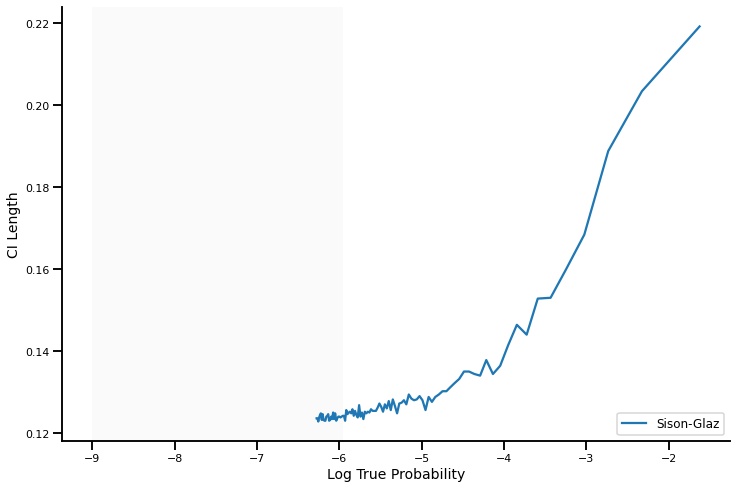

In [171]:
sns.set_context("talk")

g = sns.relplot(x='log_true_prob', y='ci_length',
                hue='exp_method', style='exp_method', #markers=True,
                kind='line', ci=None, #alpha=.55,
                height=7, aspect=1.5,
                legend=False,
                hue_order=['sison-glaz',
                              'gt_orlitsky - rule_pf_three___',
                              'gt_orlitsky - our_soution_boot___',
                              ],
            data=exp_results)
g.set_axis_labels("Log True Probability", 'CI Length', size=14)

for ax in g.axes.flatten():
    ax.legend(labels=["Sison-Glaz", 'Rule of Three', 'Good Bootstrap'], fontsize=12, #title = "Method", 
              loc=4)
    ax.tick_params( labelsize=11)
    ax.axvspan(-9, -5.952556, facecolor='lightgray', alpha=0.1)
# g.tight_layout()

<AxesSubplot:xlabel='sample_probs', ylabel='ci_length'>

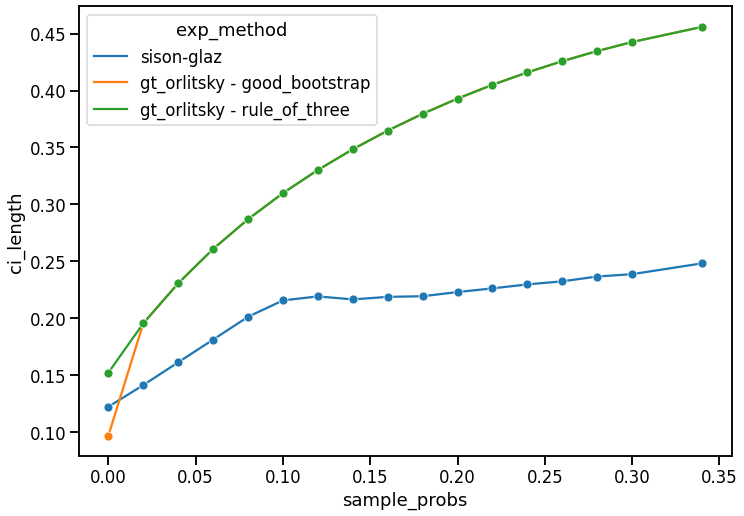

In [172]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.lineplot(x='sample_probs', y='ci_length', hue='exp_method',marker="o", ci=None,
            data=exp_results)

In [173]:
res_by_exp = exp_results.\
groupby(['exp_num','exp_method']).\
agg(in_ci = ('in_ci', 'sum'),
    ci_volume = ('ci_length', 'prod'),
    log_ci_volume = ('log_ci_length', 'sum')
).reset_index()
res_by_exp['all_in_ci'] = res_by_exp['in_ci'] == len(exp_word_list)
res_by_exp['ci_volume_log'] = np.log(res_by_exp['ci_volume'])
res_by_exp

,exp_num,exp_method,in_ci,ci_volume,log_ci_volume,all_in_ci,ci_volume_log
0,0,gt_orlitsky - good_bootstrap,100,9.906849e-91,-207.242017,True,-207.242017
1,0,gt_orlitsky - rule_of_three,100,9.275612e-79,-179.676834,True,-179.676834
2,0,sison-glaz,100,5.863121e-86,-196.253636,True,-196.253636
3,1,gt_orlitsky - good_bootstrap,100,1.794905e-107,-245.791653,True,-245.791653
4,1,gt_orlitsky - rule_of_three,100,8.232074e-79,-179.796184,True,-179.796184
...,...,...,...,...,...,...,...
295,98,gt_orlitsky - rule_of_three,100,1.376169e-78,-179.282334,True,-179.282334
296,98,sison-glaz,100,8.763698e-87,-198.154285,True,-198.154285
297,99,gt_orlitsky - good_bootstrap,100,9.915576e-84,-191.123041,True,-191.123041
298,99,gt_orlitsky - rule_of_three,100,2.927643e-78,-178.527439,True,-178.527439


In [174]:
res_by_exp.groupby(['exp_method']).agg(all_word_coverage = ('all_in_ci', 'sum'),
                                       ci_volume_mean = ('ci_volume', 'mean'),
                                      log_ci_volume_mean = ('log_ci_volume', 'mean'))

,all_word_coverage,ci_volume_mean,log_ci_volume_mean
exp_method,,,
gt_orlitsky - good_bootstrap,100,2.520856e-81,-215.823554
gt_orlitsky - rule_of_three,100,1.854273e-78,-179.130333
sison-glaz,89,1.269556e-85,-204.694275


# Scaling experiment

## sample size

In [150]:
samp_size_list = [500, 5000, 25000] #100, 500, 1000, 5000, 10000
exp_alphabet_size = 50
exp_bootstrap_smaples = 5000

distributions = [
        [get_zipf_dist_probs(1.01, exp_alphabet_size), 'zipf_1.01'],
        [get_zipf_dist_probs(1.5, exp_alphabet_size), 'zipf_1.5'],
        [get_uniform_dist_probs(exp_alphabet_size), 'uniform'],
        [get_step_dist_probs(exp_alphabet_size), 'step']
    ]

start_time = time.time()

run_results_samp_size = pd.DataFrame()
for samp_size in samp_size_list:
    exp_sample_size = samp_size
    
    for dist in distributions:
        print(dist[1] + ' - ' + str(exp_sample_size))
        exp_probs = dist[0]
        exp_word_list = get_word_list(exp_alphabet_size)
        exp_dictionary = dict(zip(exp_word_list, exp_probs))
        
        experiment_runs = 100
        pool = Pool(8)
        func = partial(run_experiment, exp_sample_size, exp_probs, exp_word_list, exp_dictionary, exp_bootstrap_smaples)
        pooled_results = pool.starmap(func, zip(range(experiment_runs)))
        pool.close()
        pool.join()
        
        ex_results = pd.concat(pooled_results)
        ex_results['alphabet_size'] = (exp_alphabet_size)
        ex_results['sample_size'] = (exp_sample_size)
        ex_results['distribution'] = dist[1]
    
        run_results_samp_size = run_results_samp_size.append(ex_results)
print("\n *********** process run time {} minutes ***********".format((time.time() - start_time)/60))


zipf_1.01 - 500
iteration 0
iteration 20
iteration 10
iteration 30
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
zipf_1.5 - 500
iteration 0
iteration 20
iteration 10
iteration 30
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
uniform - 500
iteration 0
iteration 20
iteration 30
iteration 10
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
step - 500
iteration 0
iteration 20
iteration 10
iteration 30
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
zipf_1.01 - 5000
iteration 0
iteration 20
iteration 30
iteration 10
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
zipf_1.5 - 5000
iteration 0
iteration 20
iteration 10
iteration 30
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
uniform - 5000
iteration 0
iteration 20
iteration 10
iteration 30
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iterat

In [151]:
run_results_samp_size

,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,boot_probs_min,boot_probs_max,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci,alphabet_size,sample_size,distribution
0,10y,0.22800,0.22800,sison-glaz,0.192000,0.265915,NaN,NaN,0.073915,-2.604834,0,0.226039,-1.487049,True,50,500,zipf_1.01
1,12s,0.11000,0.11000,sison-glaz,0.074000,0.147915,NaN,NaN,0.073915,-2.604834,0,0.112239,-2.187127,True,50,500,zipf_1.01
2,1qr,0.05800,0.05800,sison-glaz,0.022000,0.095915,NaN,NaN,0.073915,-2.604834,0,0.074523,-2.596647,True,50,500,zipf_1.01
3,282,0.05200,0.05200,sison-glaz,0.016000,0.089915,NaN,NaN,0.073915,-2.604834,0,0.055732,-2.887206,True,50,500,zipf_1.01
4,2sf,0.04200,0.04200,sison-glaz,0.006000,0.079915,NaN,NaN,0.073915,-2.604834,0,0.044486,-3.112581,True,50,500,zipf_1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,tnj,0.03172,0.03172,gt_orlitsky - rule_pf_three___,0.028194,0.035531,0.02740,0.03560,0.007337,-4.914888,99,0.030000,-3.506558,True,50,25000,step
146,ts8,0.03096,0.03096,gt_orlitsky - rule_pf_three___,0.027477,0.034729,0.02716,0.03556,0.007252,-4.926546,99,0.030000,-3.506558,True,50,25000,step
147,wu2,0.02840,0.02840,gt_orlitsky - rule_pf_three___,0.025065,0.032022,0.02484,0.03220,0.006956,-4.968103,99,0.030000,-3.506558,True,50,25000,step
148,xcj,0.02872,0.02872,gt_orlitsky - rule_pf_three___,0.025366,0.032360,0.02468,0.03280,0.006994,-4.962702,99,0.030000,-3.506558,True,50,25000,step


In [152]:
run_results_samp_size[#(run_results_samp_size['in_ci'] == False)
#                       &(run_results_samp_size['param_probs'] == 0) 
                      (run_results_samp_size['exp_method'] == 'sgt_dist - percentile__replace_0_mle_for_non_0')
                      &(run_results_samp_size['exp_num']==27)
                      &(run_results_samp_size['distribution']=='zipf_1.01')
                      &(run_results_samp_size['sample_size']==20)
                     ]['sample_probs'].value_counts()


Series([], Name: sample_probs, dtype: int64)

In [153]:
run_results_samp_size[(run_results_samp_size['in_ci'] == False)
#                       &(run_results_samp_size['param_probs'] == 0) 
                      &(run_results_samp_size['exp_method'] == 'sison-glaz')
                     ].head(50)
#['param_probs'].value_counts()


,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,boot_probs_min,boot_probs_max,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci,alphabet_size,sample_size,distribution
0,10y,0.18400,0.18400,sison-glaz,0.15000,0.220770,NaN,NaN,0.070770,-2.648323,14,0.226039,-1.487049,False,50,500,zipf_1.01
1,12s,0.15000,0.15000,sison-glaz,0.11400,0.187926,NaN,NaN,0.073926,-2.604695,35,0.112239,-2.187127,False,50,500,zipf_1.01
0,10y,0.18800,0.18800,sison-glaz,0.15400,0.224159,NaN,NaN,0.070159,-2.656988,42,0.226039,-1.487049,False,50,500,zipf_1.01
0,10y,0.18600,0.18600,sison-glaz,0.15200,0.223470,NaN,NaN,0.071470,-2.638475,80,0.226039,-1.487049,False,50,500,zipf_1.01
0,10y,0.18000,0.18000,sison-glaz,0.14600,0.215835,NaN,NaN,0.069835,-2.661623,82,0.226039,-1.487049,False,50,500,zipf_1.01
0,10y,0.26800,0.26800,sison-glaz,0.23000,0.307868,NaN,NaN,0.077868,-2.552739,99,0.226039,-1.487049,False,50,500,zipf_1.01
0,1dz,0.47800,0.47800,sison-glaz,0.43600,0.521399,NaN,NaN,0.085399,-2.460416,0,0.429012,-0.846272,False,50,500,zipf_1.5
0,1dz,0.47800,0.47800,sison-glaz,0.43600,0.522177,NaN,NaN,0.086177,-2.451349,23,0.429012,-0.846272,False,50,500,zipf_1.5
0,1dz,0.49600,0.49600,sison-glaz,0.45400,0.539674,NaN,NaN,0.085674,-2.457209,25,0.429012,-0.846272,False,50,500,zipf_1.5
0,1dz,0.38400,0.38400,sison-glaz,0.34200,0.428799,NaN,NaN,0.086799,-2.444156,60,0.429012,-0.846272,False,50,500,zipf_1.5


In [154]:
run_results_samp_size[(run_results_samp_size['in_ci'] == False)
            &(run_results_samp_size['param_probs'] != 0) 
#             &(run_results_samp_size['exp_method'] == 'sgt_dist - percentile_min_max')
                     ].groupby(['exp_method','distribution', 'alphabet_size', 'sample_size'])['exp_num'].nunique().head(60)


exp_method                         distribution  alphabet_size  sample_size
gt_orlitsky - our_soution_boot___  step          50             25000          5
                                   uniform       50             500            3
                                                                5000           5
                                                                25000          4
                                   zipf_1.01     50             500            5
                                                                5000           1
                                                                25000          3
                                   zipf_1.5      50             500            6
                                                                5000           5
                                                                25000          4
gt_orlitsky - rule_pf_three___     step          50             25000          5
                                 

In [155]:
run_results_samp_size[(run_results_samp_size['in_ci'] == False)
#                       &(run_results_samp_size['param_probs'] == 0) 
                      &(run_results_samp_size['exp_method'] == 'gt_orlitsky - our_soution_boot____012')]#['param_probs'].value_counts()


,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,boot_probs_min,boot_probs_max,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci,alphabet_size,sample_size,distribution


In [156]:
run_results_samp_size[(run_results_samp_size['in_ci'] == False)
            &(run_results_samp_size['param_probs'] == 0) 
            #&(run_results_samp_size['exp_method'] == 'sgt_dist - percentile_min_max')
                     ].groupby(['exp_method','distribution', 'alphabet_size', 'sample_size'])['exp_num'].nunique()


Series([], Name: exp_num, dtype: int64)

In [157]:
scale_res_by_exp_samp_size = run_results_samp_size.\
groupby(['distribution', 'exp_num','exp_method', 'alphabet_size', 'sample_size']).\
agg(in_ci = ('in_ci', 'sum'),
    ci_volume = ('ci_length', 'prod'),
    log_ci_volume = ('log_ci_length', 'sum')
).reset_index()
scale_res_by_exp_samp_size['all_in_ci'] = scale_res_by_exp_samp_size['in_ci'] == scale_res_by_exp_samp_size['alphabet_size']
scale_res_by_exp_samp_size


,distribution,exp_num,exp_method,alphabet_size,sample_size,in_ci,ci_volume,log_ci_volume,all_in_ci
0,step,0,gt_orlitsky - our_soution_boot___,50,500,50,5.625990e-70,-159.453560,True
1,step,0,gt_orlitsky - our_soution_boot___,50,5000,50,2.430815e-96,-220.159942,True
2,step,0,gt_orlitsky - our_soution_boot___,50,25000,50,7.413048e-114,-260.491459,True
3,step,0,gt_orlitsky - rule_pf_three___,50,500,50,5.625990e-70,-159.453560,True
4,step,0,gt_orlitsky - rule_pf_three___,50,5000,50,2.430815e-96,-220.159942,True
...,...,...,...,...,...,...,...,...,...
3595,zipf_1.5,99,gt_orlitsky - rule_pf_three___,50,5000,50,3.025828e-109,-249.874590,True
3596,zipf_1.5,99,gt_orlitsky - rule_pf_three___,50,25000,50,2.903632e-127,-291.362345,True
3597,zipf_1.5,99,sison-glaz,50,500,50,1.200220e-64,-147.182941,True
3598,zipf_1.5,99,sison-glaz,50,5000,50,1.105777e-86,-197.921770,True


In [158]:
scale_res_agg_samp_size = scale_res_by_exp_samp_size.groupby(['distribution', 'alphabet_size', 'sample_size', 'exp_method']).\
agg(all_word_coverage = ('all_in_ci', 'sum'),
    ci_volume_mean = ('ci_volume', 'mean'),
    log_ci_volume_mean = ('log_ci_volume', 'mean')).reset_index()
scale_res_agg_samp_size['sample_size'] = scale_res_agg_samp_size['sample_size'].apply(str)
scale_res_agg_samp_size


,distribution,alphabet_size,sample_size,exp_method,all_word_coverage,ci_volume_mean,log_ci_volume_mean
0,step,50,500,gt_orlitsky - our_soution_boot___,100,4.259751e-70,-159.879044
1,step,50,500,gt_orlitsky - rule_pf_three___,100,4.231111e-70,-159.887490
2,step,50,500,sison-glaz,97,3.373350e-70,-160.140282
3,step,50,5000,gt_orlitsky - our_soution_boot___,100,3.733422e-96,-219.752865
4,step,50,5000,gt_orlitsky - rule_pf_three___,100,3.733422e-96,-219.752865
5,step,50,5000,sison-glaz,95,3.114854e-92,-210.721536
6,step,50,25000,gt_orlitsky - our_soution_boot___,95,7.550589e-114,-260.477075
7,step,50,25000,gt_orlitsky - rule_pf_three___,95,7.550589e-114,-260.477075
8,step,50,25000,sison-glaz,94,1.130072e-109,-250.863143
9,uniform,50,500,gt_orlitsky - our_soution_boot___,97,7.684954e-69,-156.865279


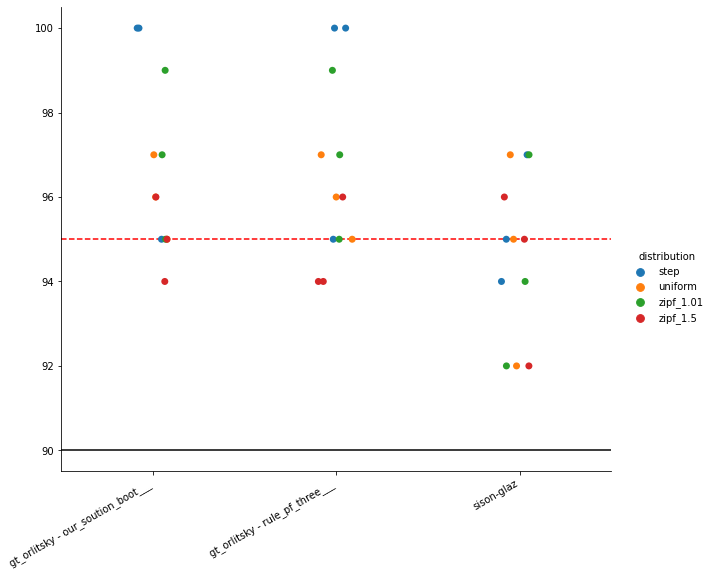

In [159]:
g= sns.catplot(x='exp_method', y='all_word_coverage', 
               hue='distribution',
            height=7,s = 7, aspect=1.2,
            data=scale_res_agg_samp_size)
g.map(plt.axhline, y=95, ls='--', c='red')
g.map(plt.axhline, y=90, c='black')
g.set_xticklabels(rotation=30, ha="right")

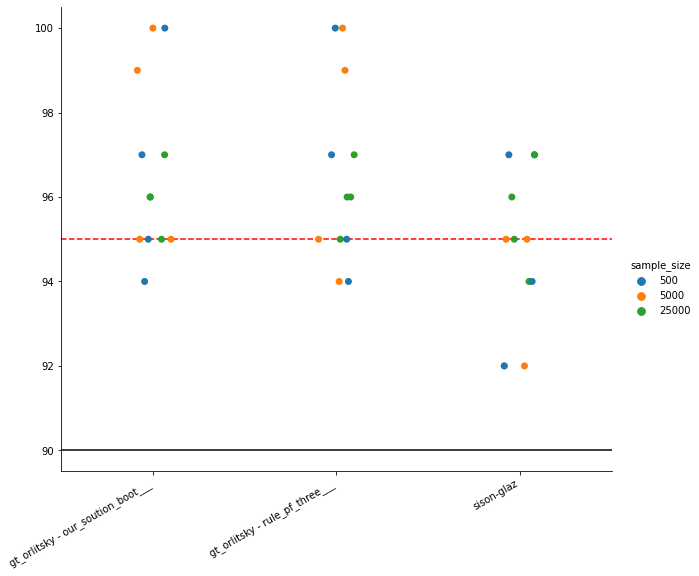

In [160]:
g= sns.catplot(x='exp_method', y='all_word_coverage', 
               hue='sample_size',
            height=7,s = 7, aspect=1.2,
            data=scale_res_agg_samp_size)
g.map(plt.axhline, y=95, ls='--', c='red')
g.map(plt.axhline, y=90, c='black')
g.set_xticklabels(rotation=30, ha="right")

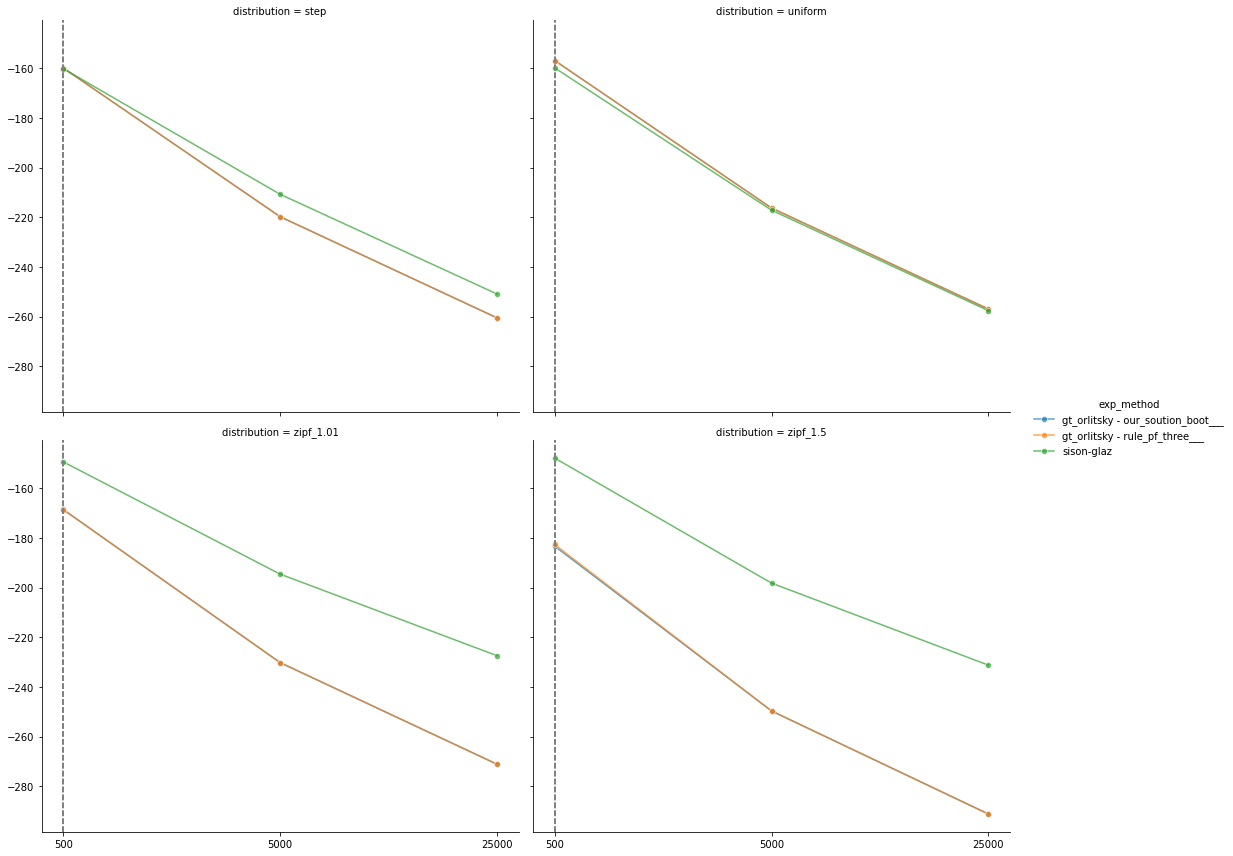

In [161]:
g = sns.FacetGrid(scale_res_agg_samp_size[~scale_res_agg_samp_size['exp_method'].isin(['gt_orlitsky - our_soution_boot__bca_',
                                                                                     'gt_orlitsky - our_soution_closed___'])] , 
                                          col='distribution',  col_wrap=2, hue='exp_method', 
                 height=6, aspect=1.2)
g.map(sns.lineplot, 'sample_size', 'log_ci_volume_mean',marker="o", alpha=.7)
g.add_legend()
g.map(plt.axvline, x=str(500), ls='--', c='gray')

# g.show_legend()
# plt.axvline(x='500', color='k', linestyle='--')

## dictionary size

In [273]:
alphabet_size_list = [7000] #1000, 2000, 3000, 4000, 5000, 6000
exp_sample_size = 500
exp_bootstrap_smaples = 20000
experiment_runs = 100

start_time = time.time()

run_results_dict_size = pd.DataFrame()
for alphabet_size in alphabet_size_list:
    exp_alphabet_size = alphabet_size
    
    distributions = [
        [get_zipf_dist_probs(1.01, exp_alphabet_size), 'zipf_1.01'],
        [get_zipf_dist_probs(1.5, exp_alphabet_size), 'zipf_1.5'],
        [get_uniform_dist_probs(exp_alphabet_size), 'uniform'],
        [get_step_dist_probs(exp_alphabet_size), 'step']
    ]
    
    for dist in distributions:
        print(dist[1] + ' - ' + str(exp_alphabet_size))
        exp_probs = dist[0]
        exp_word_list = get_word_list(exp_alphabet_size)
        exp_dictionary = dict(zip(exp_word_list, exp_probs))
        
        pool = Pool(8)
        func = partial(run_experiment, exp_sample_size, exp_probs, exp_word_list, exp_dictionary, exp_bootstrap_smaples)
        pooled_results = pool.starmap(func, zip(range(experiment_runs)))
        pool.close()
        pool.join()
        
        ex_results = pd.concat(pooled_results)
        ex_results['alphabet_size'] = (exp_alphabet_size)
        ex_results['sample_size'] = (exp_sample_size)
        ex_results['distribution'] = dist[1]
    
        run_results_dict_size = run_results_dict_size.append(ex_results)
print("\n *********** process run time {} minutes ***********".format((time.time() - start_time)/60))


zipf_1.01 - 7000
iteration 0
iteration 20
iteration 30
iteration 10
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
zipf_1.5 - 7000
iteration 0
iteration 20
iteration 10
iteration 30
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
uniform - 7000
iteration 0
iteration 20
iteration 30
iteration 10
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90
step - 7000
iteration 0
iteration 20
iteration 30
iteration 10
iteration 40
iteration 60
iteration 50
iteration 80
iteration 70
iteration 90

 *********** process run time 274.23608121474587 minutes ***********


In [274]:
run_results_dict_size

,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,boot_probs_min,boot_probs_max,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci,alphabet_size,sample_size,distribution
0,000,0.094,0.094000,sison-glaz,0.068,0.120300,NaN,NaN,0.052300,-2.950763,0,0.110484,-2.202881,True,7000,500,zipf_1.01
1,003,0.062,0.062000,sison-glaz,0.036,0.088300,NaN,NaN,0.052300,-2.950763,0,0.054861,-2.902960,True,7000,500,zipf_1.01
2,00c,0.028,0.028000,sison-glaz,0.002,0.054300,NaN,NaN,0.052300,-2.950763,0,0.036426,-3.312479,True,7000,500,zipf_1.01
3,00d,0.028,0.028000,sison-glaz,0.002,0.054300,NaN,NaN,0.052300,-2.950763,0,0.027241,-3.603038,True,7000,500,zipf_1.01
4,00l,0.020,0.020000,sison-glaz,0.000,0.046300,NaN,NaN,0.046300,-3.072618,0,0.021744,-3.828413,True,7000,500,zipf_1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,zyz,0.000,0.000117,gt_orlitsky - rule_pf_three___,0.000,0.023699,0.0,0.004,0.023699,-3.742331,99,0.000214,-8.448200,True,7000,500,step
20996,zz1,0.000,0.000117,gt_orlitsky - rule_pf_three___,0.000,0.023699,0.0,0.006,0.023699,-3.742331,99,0.000214,-8.448200,True,7000,500,step
20997,zzh,0.000,0.000117,gt_orlitsky - rule_pf_three___,0.000,0.023699,0.0,0.006,0.023699,-3.742331,99,0.000214,-8.448200,True,7000,500,step
20998,zzj,0.000,0.000117,gt_orlitsky - rule_pf_three___,0.000,0.023699,0.0,0.006,0.023699,-3.742331,99,0.000214,-8.448200,True,7000,500,step


In [292]:
run_results_dict_size.to_csv('/Users/danielmarton/Documents/thesis/experiments/exp_dict_sis_rot_boot_1000_to_5000.csv')
# res_6000 = pd.read_csv('/Users/danielmarton/Documents/thesis/experiments/exp_dict_sis_rot_boot_6000.csv')
# run_results_dict_size = run_results_dict_size.append(res_6000, ignore_index=True)

In [295]:
# run_results_dict_size = pd.read_csv('/Users/danielmarton/Documents/thesis/experiments/exp_dict_sis_rot_boot_1000_to_5000.csv')
# res_6000 = pd.read_csv('/Users/danielmarton/Documents/thesis/experiments/exp_dict_sis_rot_boot_6000.csv')
# res_7000 = pd.read_csv('/Users/danielmarton/Documents/thesis/experiments/exp_dict_sis_rot_boot_7000.csv')

# run_results_dict_size = run_results_dict_size.append(pd.concat([res_6000,res_7000], ignore_index=True), ignore_index=True)

In [296]:
run_results_dict_size[(run_results_dict_size['in_ci'] == False)
            &(run_results_dict_size['param_probs'] != 0) 
            &(run_results_dict_size['exp_method'] == 'sgt_dist - percentile__replace_0_mle_for_non_0')]#['param_probs'].value_counts()


,Unnamed: 0,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,boot_probs_min,boot_probs_max,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci,alphabet_size,sample_size,distribution,fail_cov_exp


In [297]:
run_results_dict_size[(run_results_dict_size['in_ci'] == False)
            &(run_results_dict_size['param_probs'] != 0) 
           # &(run_results_dict_size['exp_method'] == 'sgt_dist - percentile_min_max')
                     ].groupby(['exp_method','distribution', 'alphabet_size', 'sample_size'])['exp_num'].nunique()


exp_method                         distribution  alphabet_size  sample_size
gt_orlitsky - our_soution_boot___  step          1000           500             1
                                                 2000           500             1
                                                 3000           500             1
                                                 4000           500             1
                                   uniform       1000           500             3
                                                 2000           500             3
                                                 3000           500             1
                                                 5000           500             2
                                                 6000           500             1
                                                 7000           500             1
                                   zipf_1.01     2000           500             1
                      

In [298]:
flt = run_results_dict_size[(run_results_dict_size['in_ci']==False)]['exp_num'].unique()
flt.sort()
flt
# run_results_dict_size[(run_results_dict_size['exp_num'].isin(flt))]['exp_num'].unique().shape

array([ 0,  1,  2,  4,  5,  8,  9, 11, 12, 15, 16, 18, 19, 20, 24, 25, 27,
       28, 29, 32, 33, 34, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 51, 52,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 70, 71, 74, 76,
       80, 82, 87, 88, 90, 91, 92, 93, 94, 95, 97, 99])

In [299]:
run_results_dict_size

,Unnamed: 0,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,boot_probs_min,boot_probs_max,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci,alphabet_size,sample_size,distribution,fail_cov_exp
0,0,000,0.132,0.132000,sison-glaz,0.102,0.162064,NaN,NaN,0.060064,-2.812350,0,0.137874,-1.981412,True,1000,500,zipf_1.01,False
1,1,01l,0.074,0.074000,sison-glaz,0.044,0.104064,NaN,NaN,0.060064,-2.812350,0,0.068461,-2.681491,True,1000,500,zipf_1.01,False
2,2,033,0.050,0.050000,sison-glaz,0.020,0.080064,NaN,NaN,0.060064,-2.812350,0,0.045456,-3.091011,True,1000,500,zipf_1.01,False
3,3,03i,0.038,0.038000,sison-glaz,0.008,0.068064,NaN,NaN,0.060064,-2.812350,0,0.033994,-3.381570,True,1000,500,zipf_1.01,False
4,4,03t,0.032,0.032000,sison-glaz,0.002,0.062064,NaN,NaN,0.060064,-2.812350,0,0.027135,-3.606945,True,1000,500,zipf_1.01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33599995,20995,zyz,0.000,0.000117,gt_orlitsky - rule_pf_three___,0.000,0.023699,0.0,0.004,0.023699,-3.742331,99,0.000214,-8.448200,True,7000,500,step,NaN
33599996,20996,zz1,0.000,0.000117,gt_orlitsky - rule_pf_three___,0.000,0.023699,0.0,0.006,0.023699,-3.742331,99,0.000214,-8.448200,True,7000,500,step,NaN
33599997,20997,zzh,0.000,0.000117,gt_orlitsky - rule_pf_three___,0.000,0.023699,0.0,0.006,0.023699,-3.742331,99,0.000214,-8.448200,True,7000,500,step,NaN
33599998,20998,zzj,0.000,0.000117,gt_orlitsky - rule_pf_three___,0.000,0.023699,0.0,0.006,0.023699,-3.742331,99,0.000214,-8.448200,True,7000,500,step,NaN


In [300]:
run_results_dict_size['fail_cov_exp'] = ~run_results_dict_size\
.groupby(['distribution', 'alphabet_size', 'sample_size','exp_num' , 'exp_method'])\
.agg(jjj = ('in_ci', np.all))\
.reset_index()['jjj']

run_results_dict_size.fail_cov_exp.unique()

array([False, True, nan], dtype=object)

In [301]:

# run_results_dict_size['exp_num'] = run_results_dict_size['exp_num'].apply(str)
# sns.relplot(x='sample_probs', y='ci_length', 
#             hue='exp_num', col='alphabet_size', col_wrap=3,
#             marker="o", ci=False, kind='line',
#             data=run_results_dict_size[(run_results_dict_size['exp_method'] == 'sgt_dist - percentile_min_max')
#                                        &(run_results_dict_size['param_probs'] != 0)
#                                      &(run_results_dict_size['fail_cov_exp'] == True)
#                                       ])


In [302]:
run_results_dict_size[(run_results_dict_size['in_ci'] == False)
            &(run_results_dict_size['param_probs'] == 0) 
            &(run_results_dict_size['exp_method'] == 'sgt_dist - percentile_min_max')]#['param_probs'].value_counts()


,Unnamed: 0,word,sample_probs,param_probs,exp_method,ci_lower,ci_upper,boot_probs_min,boot_probs_max,ci_length,log_ci_length,exp_num,true_prob,log_true_prob,in_ci,alphabet_size,sample_size,distribution,fail_cov_exp


In [303]:
run_results_dict_size[(run_results_dict_size['in_ci'] == False)
            &(run_results_dict_size['param_probs'] == 0) 
            &(run_results_dict_size['exp_method'] == 'sgt_dist - percentile_min_max')].groupby(['distribution', 'alphabet_size', 'sample_size'])['exp_num'].nunique()


Series([], Name: exp_num, dtype: int64)

In [304]:
scale_res_by_exp_dict_size = run_results_dict_size.\
groupby(['distribution', 'exp_num','exp_method', 'alphabet_size', 'sample_size']).\
agg(in_ci = ('in_ci', 'sum'),
    ci_volume = ('ci_length', 'prod'),
    log_ci_volume = ('log_ci_length', 'sum')
).reset_index()
scale_res_by_exp_dict_size['all_in_ci'] = scale_res_by_exp_dict_size['in_ci'] == scale_res_by_exp_dict_size['alphabet_size']
scale_res_by_exp_dict_size


,distribution,exp_num,exp_method,alphabet_size,sample_size,in_ci,ci_volume,log_ci_volume,all_in_ci
0,step,0,gt_orlitsky - our_soution_boot___,1000,500,1000,0.0,-4389.671646,True
1,step,0,gt_orlitsky - our_soution_boot___,2000,500,2000,0.0,-9231.874894,True
2,step,0,gt_orlitsky - our_soution_boot___,3000,500,3000,0.0,-14017.138403,True
3,step,0,gt_orlitsky - our_soution_boot___,4000,500,4000,0.0,-19826.391628,True
4,step,0,gt_orlitsky - our_soution_boot___,5000,500,5000,0.0,-24960.470126,True
...,...,...,...,...,...,...,...,...,...
8395,zipf_1.5,99,sison-glaz,3000,500,3000,0.0,-9436.129313,True
8396,zipf_1.5,99,sison-glaz,4000,500,4000,0.0,-12634.181226,True
8397,zipf_1.5,99,sison-glaz,5000,500,5000,0.0,-15811.473135,True
8398,zipf_1.5,99,sison-glaz,6000,500,6000,0.0,-18891.829986,True


In [305]:
scale_res_agg_dict_size = scale_res_by_exp_dict_size.groupby(['distribution', 'alphabet_size', 'sample_size', 'exp_method']).\
agg(all_word_coverage = ('all_in_ci', 'sum'),
    ci_volume_mean = ('ci_volume', 'mean'),
    log_ci_volume_mean = ('log_ci_volume', 'mean')).reset_index()
scale_res_agg_dict_size['sample_size'] = scale_res_agg_dict_size['sample_size'].apply(str)
scale_res_agg_dict_size['alphabet_size'] = scale_res_agg_dict_size['alphabet_size'].apply(str)

scale_res_agg_dict_size


,distribution,alphabet_size,sample_size,exp_method,all_word_coverage,ci_volume_mean,log_ci_volume_mean
0,step,1000,500,gt_orlitsky - our_soution_boot___,99,0.0,-4350.933757
1,step,1000,500,gt_orlitsky - rule_pf_three___,99,0.0,-3798.581419
2,step,1000,500,sison-glaz,98,0.0,-4256.078938
3,step,2000,500,gt_orlitsky - our_soution_boot___,99,0.0,-9410.710320
4,step,2000,500,gt_orlitsky - rule_pf_three___,99,0.0,-7583.733152
...,...,...,...,...,...,...,...
79,zipf_1.5,6000,500,gt_orlitsky - rule_pf_three___,100,0.0,-22497.502754
80,zipf_1.5,6000,500,sison-glaz,94,0.0,-18861.488225
81,zipf_1.5,7000,500,gt_orlitsky - our_soution_boot___,100,0.0,-28542.163145
82,zipf_1.5,7000,500,gt_orlitsky - rule_pf_three___,100,0.0,-26161.130785


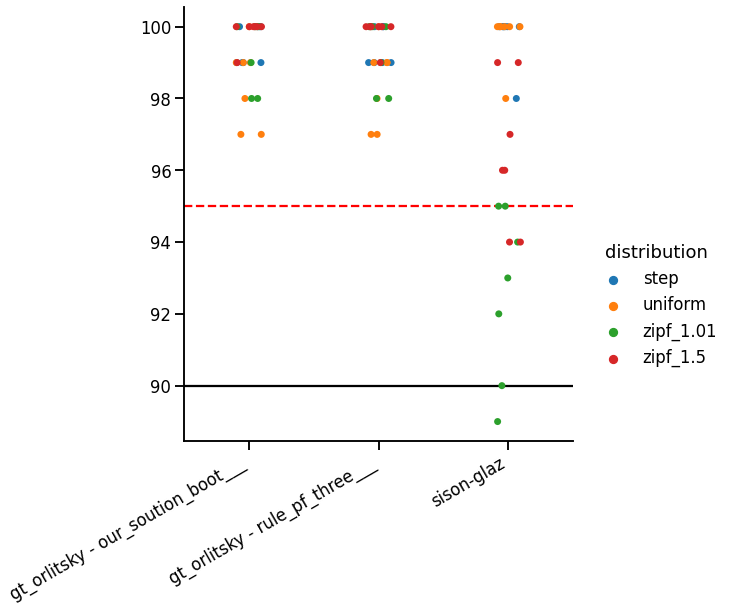

In [306]:
g= sns.catplot(x='exp_method', y='all_word_coverage', 
               hue='distribution',
            height=7,s = 7,
            data=scale_res_agg_dict_size)
g.map(plt.axhline, y=95, ls='--', c='red')
g.map(plt.axhline, y=90, c='black')
g.set_xticklabels(rotation=30, ha="right")

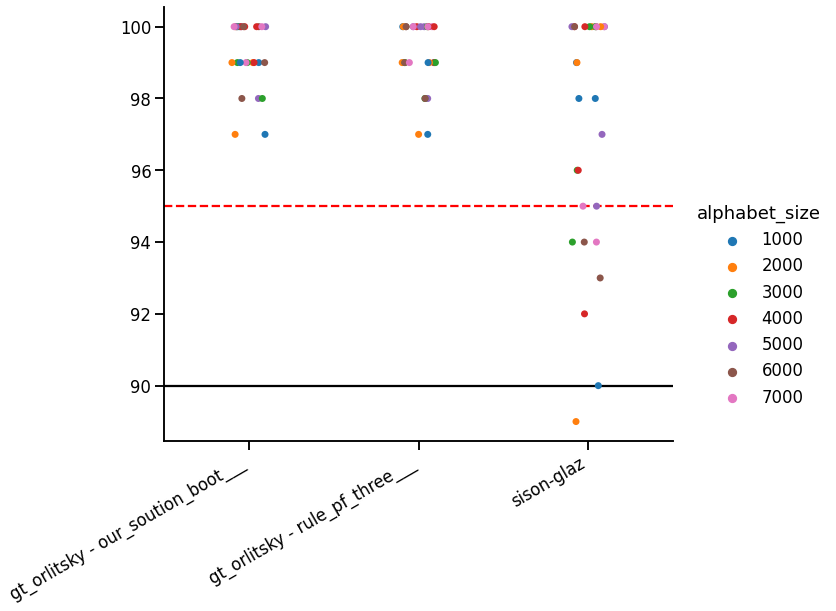

In [307]:
g= sns.catplot(x='exp_method', y='all_word_coverage', 
               hue='alphabet_size',
            height=7,s = 7, aspect=1.2,
            data=scale_res_agg_dict_size)
g.map(plt.axhline, y=95, ls='--', c='red')
g.map(plt.axhline, y=90, c='black')
g.set_xticklabels(rotation=30, ha="right")

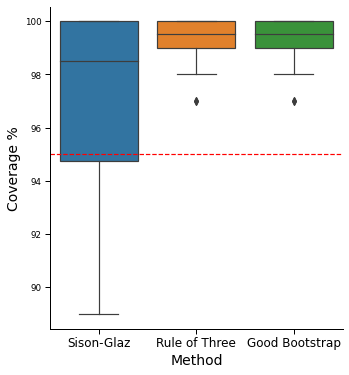

In [313]:
sns.set_context('paper')
g= sns.catplot(x='exp_method', y='all_word_coverage', 
#                hue='sample_size',
               order=['sison-glaz',
                              'gt_orlitsky - rule_pf_three___',
                              'gt_orlitsky - our_soution_boot___',
                              ],
             kind='box',#s = 7,
            data=scale_res_agg_dict_size)
g.map(plt.axhline, y=95, ls='--', c='red')
# g.map(plt.axhline, y=90, c='black')
# g.set_xticklabels(rotation=30, ha="right")
g.set_xticklabels(["Sison-Glaz", 'Rule of Three', 'Good Bootstrap'], size=12)
g.set_axis_labels("Method", 'Coverage %', size=14)


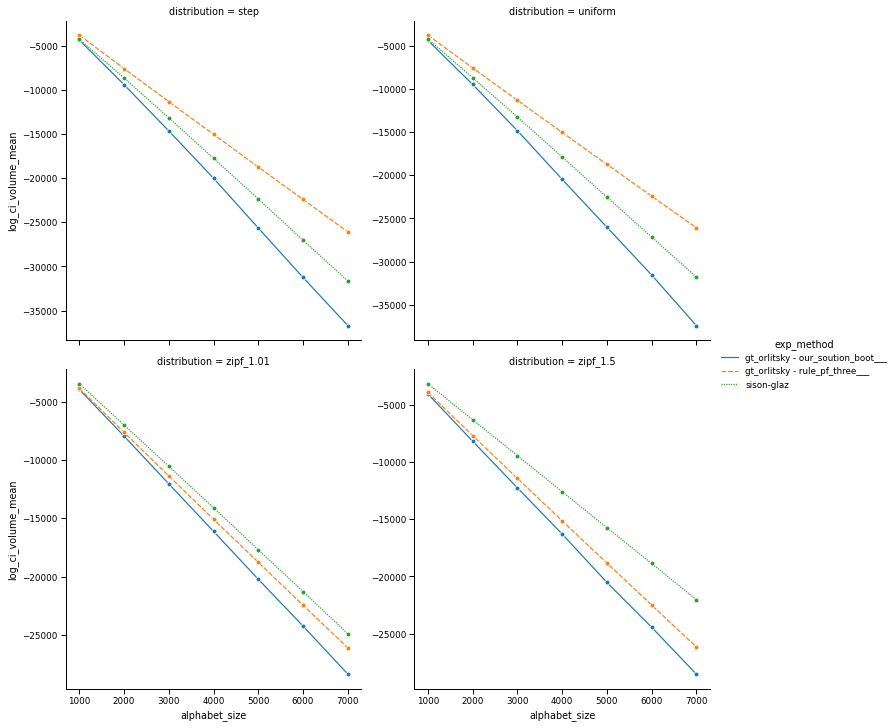

In [310]:

g = sns.relplot(x='alphabet_size', y='log_ci_volume_mean', col='distribution',
            hue='exp_method',marker="o", style='exp_method', col_wrap=2,
            kind='line', facet_kws={'sharey':False},
           data=scale_res_agg_dict_size[~scale_res_agg_dict_size['exp_method'].isin(['gt_orlitsky - our_soution_boot__bca_',
                                                                                     'gt_orlitsky - our_soution_closed___'])])
# g.map(plt.axvline, x=str(500), ls='--', c='gray')


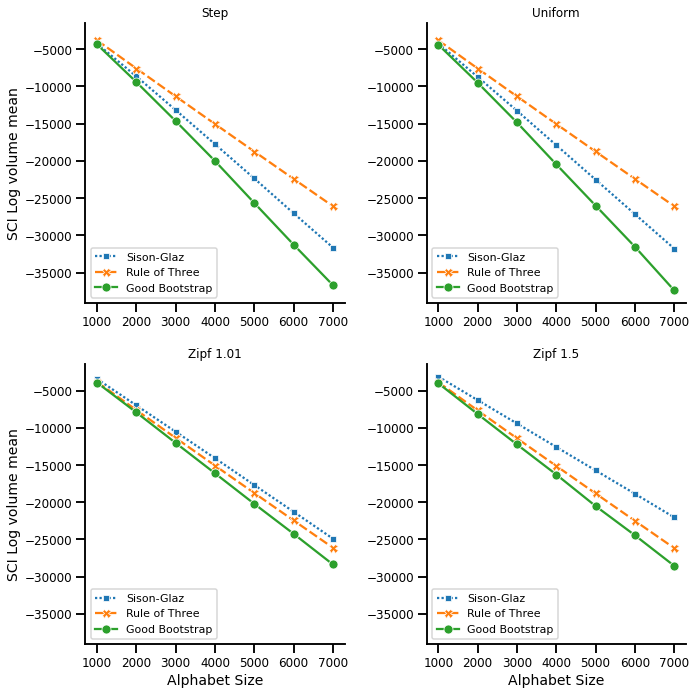

In [311]:
sns.set_context("talk")
g = sns.relplot(x='alphabet_size', y='log_ci_volume_mean', col='distribution', col_wrap=2,#row='distribution', #col='sample_size',
            hue='exp_method', style='exp_method', markers=True, legend=False,
            kind='line', facet_kws={'sharey': True, 'sharex': True},
                hue_order=['sison-glaz',
                              'gt_orlitsky - rule_pf_three___',
                              'gt_orlitsky - our_soution_boot___',
                              ],
           data=scale_res_agg_dict_size
           )
g.set_axis_labels("Alphabet Size", 'SCI Log volume mean', size=14)

for ax,title in zip(g.axes.flatten(),['Step','Uniform','Zipf 1.01','Zipf 1.5']):
    ax.set_title(title, size=12)
    ax.legend(labels=["Sison-Glaz", 'Rule of Three', 'Good Bootstrap'], fontsize=11, #title = "Method", 
              loc=3)
    ax.tick_params( labelsize=12, labelbottom=True, labelleft=True)
g.tight_layout()